In [1]:
import matplotlib.pyplot as plt
from ParticleTracerLatticeClass import ParticleTracerLattice
import scipy.interpolate as spi
import sys
from ParaWell import ParaWell
from ParticleTracerClass import ParticleTracer
from ParticleClass import Swarm, Particle
import time
from SwarmTracerClass import SwarmTracer
import scipy.optimize as spo
import numpy as np
import os

rFact=.675

PTL = ParticleTracerLattice(200.0)
PTL.add_Halbach_Lens_Sim(.01, .5)
PTL.add_Combiner_Sim('combinerV2.txt')
PTL.add_Halbach_Lens_Sim(.01, .5)
PTL.add_Halbach_Bender_Sim_Segmented_With_End_Cap(.0254, .01, None, 1.0, 1e-3, rOffsetFact=rFact)
PTL.add_Halbach_Lens_Sim(.01, None)
PTL.add_Halbach_Bender_Sim_Segmented_With_End_Cap(.0254, .01, None, 1.0, 1e-3, rOffsetFact=rFact)
PTL.end_Lattice(constrain=True,enforceClosedLattice=True,surpressWarning=True)

1.7076243919042253 0.0


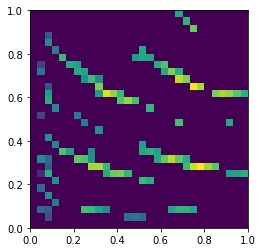

In [23]:
h = 1e-5
T = 1.0
swarmTracer = SwarmTracer(PTL)
swarm0 = swarmTracer.generate_Probe_Sample(200.0, seed=42)
swarm0 = swarmTracer.move_Swarm_To_Combiner_Output(swarm0)
swarmTest=Swarm()
swarmTest.add_Particle()
swarmTest.add_Particle(qi=np.asarray([-1e-10,1e-3,0]))
swarmTest.add_Particle(qi=np.asarray([-1e-10,-1e-3,0]))
swarmTest.add_Particle(qi=np.asarray([-1e-10,0,-1e-3]))
swarmTest.add_Particle(qi=np.asarray([-1e-10,0,1e-3]))


num0=30
BArr=np.linspace(0,1.0,num0)
coordsArr=np.asarray(np.meshgrid(BArr,BArr)).T.reshape(-1,2)
def revFunc(X,parallel=False):
    # if (X[0]==0 or X[0]==1) and X[1]==1:
    #     return 0.0
    # if X[0]==1 and X[1]==0:
    #     return 10.0
    PTL.elList[2].set_BpFact(X[0])
    PTL.elList[4].set_BpFact(X[1])
    minRevs = 5.0  # test particle must achieve at least this many revolutions
    swarmTestNew=swarmTracer.trace_Swarm_Through_Lattice(swarmTest,1e-5,1.5 * minRevs * PTL.totalLength / 200.0,parallel=parallel)
    stable=False
    for particle in swarmTestNew:
        if particle.revolutions>minRevs:
            stable=True
    if stable==False:
        return 0.0
    else:
        swarm = swarmTracer.trace_Swarm_Through_Lattice(swarm0, 1e-5, T, parallel=parallel, fastMode=True)
        # print(X,swarm.survival_Rev())
        return swarm.survival_Rev()



helper=ParaWell()
t=time.time()
results=helper.parallel_Problem(revFunc,coordsArr,onlyReturnResults=True)
val0Arr=np.asarray(results)
image=val0Arr.reshape(num0,num0)
image=np.flip(np.transpose(image),axis=0)
extent=[0.0,1.0,0.0,1.0]
print(np.max(image),np.min(image)) 
plt.imshow(image,extent=extent)
plt.show()

In [3]:
# import scipy.ndimage as spimg
# valArr=val0Arr.copy()
# imageVal0Arr=valArr.reshape(num0,num0)
# # stableIndices=np.argwhere(imageVal0Arr!=0) #indices that represent stable solutions
# # imageValArrSmooth=spimg.gaussian_filter(imageVal0Arr,num0/30)
# # imageValArrSmooth=imageValArrSmooth*(valArr.max()/imageValArrSmooth.max())*.5
# # print(imageValArrSmooth.max())
# # imageValArrSmooth[tuple(np.hsplit(stableIndices,2))]=imageVal0Arr[tuple(np.hsplit(stableIndices,2))]
# plt.imshow(imageVal0Arr)
# plt.show()
# # valArr=np.ravel(imageValArrSmooth)

In [4]:
# import scipy.interpolate as spi
# fitFunc=spi.RBFInterpolator(coordsArr,valArr)
# num=150
# BArr=np.linspace(0,1.0,num)
# testCoords=np.asarray(np.meshgrid(BArr,BArr)).T.reshape(-1,2)
# testVals=fitFunc(testCoords)

# imageTest=testVals.reshape(num,num)
# print(np.max(imageTest),np.min(imageTest))
# plt.imshow(np.abs(imageTest))
# plt.show()

In [24]:
def optimize(smoothing):
    np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
    bounds=[(0,1.0),(0,1.0)]
    newCoords=coordsArr.copy()
    newVals=val0Arr.copy()
    progressList=[np.max(newVals)]
    fitFunc=None
    for i in range(100):
        fitFunc=spi.RBFInterpolator(newCoords,newVals,smoothing=smoothing)
        def minFunc(X):
            return 1/np.abs(fitFunc([X])[0])
        probeVals=[]
        probeCoords=[]
        for j in range(10):
            sol=spo.differential_evolution(minFunc,bounds,mutation=1.5)
            probeVals.append(1/sol.fun)
            probeCoords.append(sol.x)
        bestProbeVal=max(probeVals)
        bestProbeCoords=probeCoords[np.argmax(np.asarray(probeVals))]
        print('best probe vals',bestProbeVal,bestProbeCoords)
        newVal=revFunc(bestProbeCoords,parallel=True)
        newCoords=np.row_stack((newCoords,bestProbeCoords))
        newVals=np.append(newVals,newVal)
        progressList.append(np.max(newVals))
        print('result',newVal)
    print('initial value:',np.round(np.max(val0Arr),2),'new value: ',np.round(np.max(newVals),2))
    return fitFunc,progressList
fitFunc,progressList=optimize(0.0)

best probe vals 1.7429740752191698 [0.76471227 0.65524686]
result 1.7033668327550648
best probe vals 1.7126228204522875 [0.76175965 0.65534439]
result 1.7003928353395925
best probe vals 1.707722333855128 [0.79294721 0.27583336]
result 1.6907752773323343
best probe vals 1.8107960119503916 [0.79788958 0.27641917]
result 1.6381229167842053
best probe vals 1.7361222662612221 [0.79413887 0.27610893]
result 1.6764463669999188
best probe vals 1.7128129365696783 [0.79329113 0.27585771]
result 1.6549237806388444
best probe vals 1.9099767061307202 [0.79246402 0.2805273 ]
result 1.5792773378050742
best probe vals 1.729483335487836 [0.79298435 0.2770588 ]
result 1.7089340314388246
best probe vals 1.7124216339147214 [0.7928995  0.27649301]
result 1.676879543386887
best probe vals 1.7207859507490164 [0.79365506 0.27758598]
result 1.6466133731578498
best probe vals 1.710640460477469 [0.79285927 0.27713483]
result 1.669821771151371
best probe vals 1.7221274217121696 [0.79317247 0.27696181]
result 1.69

best probe vals 1.8089471682559564 [0.77025673 0.65102824]
result 1.7576021161653097
best probe vals 1.7893053010346278 [0.77023607 0.6510799 ]
result 1.7757630374534454
best probe vals 1.8443780991797911 [0.7702154  0.65106266]
result 1.7795837439535502
initial value: 1.71 new value:  1.8


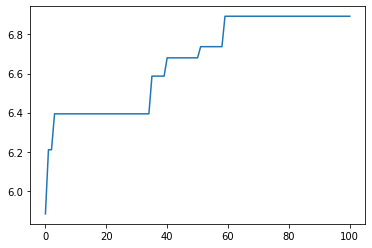

In [22]:
plt.plot(progressList)
plt.show()

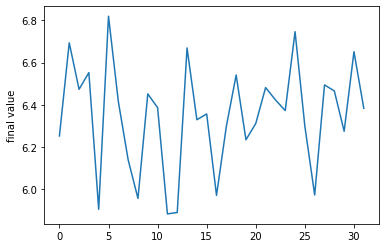

In [18]:
sList=[]
finalValList=[]
for result in results:
    sList.append(result[0])
    finalValList.append(result[1][-1])
#     plt.plot(result[1])
# plt.show()
# plt.xlabel('smoothing')
plt.ylabel('final value')
plt.plot(finalValList)
plt.show()

In [12]:
import numpy as np
a=np.asarray([1.0,2.0,3.0])
b=np.asarray([4.0,5.0,6.0])
c=7.0
np.append(np.append(a,b),c)

array([1., 2., 3., 4., 5., 6., 7.])

Designing an improved differential evolution algorithm. Works by making a non parametric model of a grid of solutions, then tries to find the best solution. Below are approaches, and their results. using 30x30 grid first
1: generate grid of survival without any stability considerations to try and save time. Generating grid takes a while. 
2: use stability criteria to try and speed up results. Problem is that there are now hard edges in the model that can screw things up 
    a: no smoothing